# RNN Process for Free Sound Audio Tagging

## Imports 

In [0]:
import tensorflow.compat.v1 as tf #Note for this process I needed to use tensflow 1
tf.disable_v2_behavior()
import tensorflow as tf2
from tensorflow.python.ops import rnn, rnn_cell
import pickle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, scale
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import os 
import glob
import librosa
import time
import librosa.display as dis
import matplotlib.pyplot as plt
import imageio
import sklearn

## Mount the location of the audio files 

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
train_dir = '/content/gdrive/My Drive/NoiseX/data/FSA_curated_train_samples/'
test_dir = '/content/gdrive/My Drive/NoiseX/data/FSDKaggle2019.audio_test/'
mehta_dir = '/content/gdrive/My Drive/NoiseX/data/FSA_mehta/'

## Audio Processsing Parameters

In [0]:
audio_length = 2
sampling_rate = 44100
step = 512
time_steps = audio_length * sampling_rate // step

## Investigate Audio File

(20, 304)


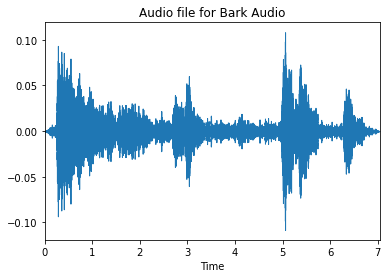

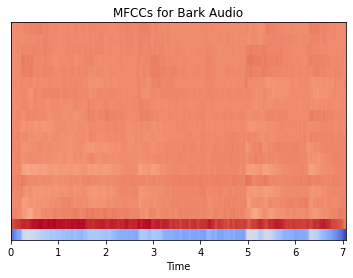

In [0]:
audio_fname = '/content/gdrive/My Drive/NoiseX/data/FSA_curated_train_samples/0006ae4e.wav'
x, fs = librosa.load(audio_fname)
df = pd.read_csv(label_file)
df = df.set_index('fname')
label = df.loc['0006ae4e.wav'].labels
fig1 = plt.figure(1)
librosa.display.waveplot(x,sr =fs)
plt.title('Audio file for ' + label + ' Audio')
fig1.show()

fig2 = plt.figure(2)
mfccs = librosa.feature.mfcc(x, sr = fs)
print(mfccs.shape)
librosa.display.specshow(mfccs, sr = fs, x_axis='time')
plt.title('MFCCs for ' + label + ' Audio')
fig2.show()

## Feature Scaling
Scale the MFCCs such that each coeffcient dimension has zero mean and unit variance: 

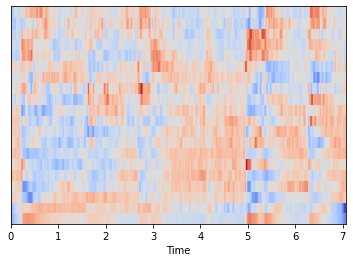

In [0]:
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
librosa.display.specshow(mfccs, sr=fs, x_axis='time')

## Convert MFCCss to Lower Dimension

Text(0.5, 0, 'Frame Index')

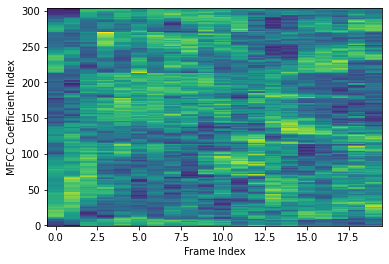

In [0]:
mfccs = sklearn.preprocessing.scale(mfccs)
plt.imshow(mfccs.T, origin='lower', aspect='auto', interpolation='nearest')
plt.ylabel('MFCC Coefficient Index')
plt.xlabel('Frame Index')

## Define RNN Parameters

In [1]:
learning_rate = 0.001
display_step = 50
test_step = 200
nb_epochs = 2000
batch_size = 64
n_features = 20
rnn_sizes = [128, 128]
model_name = 'mfcc_cross'
load_model_name = 'mfcc_cross'
load = False #Set to false when training, true when testing
export_dir = '/content/gdrive/My Drive/NoiseX/rnn_networks/'
import_dir = '/content/gdrive/My Drive/NoiseX/data/'
label_file = mehta_dir + 'train_curated_post_competition.csv'

NameError: ignored

## One Hot Encode Classes

In [0]:
def enc_hot(df):
  number_samples = df.shape[0]
  print('Number of training samples: ' + str(number_samples))
  encoder = LabelEncoder()
  encoder.fit(df.label)
  num_classes = len(encoder.classes_)

  #One hot encode
  encoded_hot = OneHotEncoder()
  encoded_hot.fit(encoder.transform(df.label).reshape(-1,1))

  label = encoded_hot.transform(encoder.transform(df.label).reshape(-1,1)).toarray()
  return label,num_classes

## Get MFC Features for Train/Test Set

In [0]:
def extract_mfcc(train = False):
    if train:
        df = pd.read_csv(label_file)
        df = df.set_index('fname')
        labels = []
        verifieds = []
        path = train_dir
    else:
        path = test_dir
    mfccs = []
    fnames = []
    count = 0 
    for filename in glob.glob(os.path.join(path, '*.wav' )):
          fname = filename.split('/')[-1]
          if train:
              label = df.loc[fname].labels
          sound_clip, s = librosa.load(filename, sr = sampling_rate)
          try:
              mfcc = librosa.feature.mfcc(y=sound_clip,sr = s , n_mfcc = n_features).T
          except ValueError:
              # Some files cause errors
              mfcc = np.ones((10,n_features))
          file_time_steps,_ = mfcc.shape

          mfcc = scale(mfcc,axis=0)

          # Sometimes need to pad with zeros so all files have same time_steps
          pad = time_steps - file_time_steps % time_steps

          #Pad with zeros 
          if pad < time_steps // 3 or file_time_steps // time_steps == 0:
              mfcc = np.pad(mfcc, ((0,pad),(0,0)), mode = 'constant', constant_values = (0,0))
              mfcc = mfcc.reshape(file_time_steps // time_steps + 1, time_steps, n_features)

          # remove last part if too short
          else:
            mfcc = mfcc[:file_time_steps // time_steps * time_steps, :]
            mfcc = mfcc.reshape(file_time_steps // time_steps, time_steps, n_features)
          
          for i in range(mfcc.shape[0]):
                  mfccs.append(mfcc[i, :, :])
                  fnames.append(fname)
                  if train:
                      labels.append(label)
          print('Length of ' + fname +  ' MFCC Array: ' + str(mfcc.shape[0]))
          count += 1
          if count % 100 == 0:
              print("file {}".format(count))
    if train:
          df_mfcc = pd.DataFrame({
              'fname': fnames,
              'label': labels,
          })
          
          df_mfcc.to_csv(import_dir + 'mfcc_train.csv')
          with open('/content/gdrive/My Drive/NoiseX/data/mfcc_input_pickle/mfcc_train.p', 'wb') as fp:
            pickle.dump(np.array(mfccs), fp)
    else:
      df_mfcc = pd.DataFrame({
            'fname': fnames,})
      df_mfcc.to_csv(import_dir + 'mfcc_test.csv')
      with open('/content/gdrive/My Drive/NoiseX/data/mfcc_input_pickle/mfcc_test.p', 'wb') as fp:
              pickle.dump(np.array(mfccs), fp)
  



In [0]:
extract_mfcc()

Length of 6f946ca7.wav MFCC Array: 6
Length of 23756062.wav MFCC Array: 6
Length of 597d9d6f.wav MFCC Array: 12
Length of 0dcf1534.wav MFCC Array: 7
Length of d722b419.wav MFCC Array: 9
Length of d0b2b9df.wav MFCC Array: 6
Length of 546c06a9.wav MFCC Array: 7
Length of 593fe1fb.wav MFCC Array: 9
Length of a328f50e.wav MFCC Array: 7
Length of 27d43eba.wav MFCC Array: 8
Length of f5adf3f9.wav MFCC Array: 9
Length of b91aa5ec.wav MFCC Array: 9
Length of ed69b289.wav MFCC Array: 7
Length of fc8e756e.wav MFCC Array: 9
Length of 7ff488db.wav MFCC Array: 11
Length of 717ca867.wav MFCC Array: 7
Length of 603837b7.wav MFCC Array: 9
Length of 0b4819f1.wav MFCC Array: 8
Length of fb79f1c6.wav MFCC Array: 6
Length of dbc4450e.wav MFCC Array: 6
Length of 2f84c8e9.wav MFCC Array: 8
Length of c6b7e823.wav MFCC Array: 9
Length of ee3358bd.wav MFCC Array: 6
Length of 7113b3fd.wav MFCC Array: 13
Length of bdee5843.wav MFCC Array: 12
Length of 020b1fdf.wav MFCC Array: 12
Length of 47a6ab8e.wav MFCC Array

In [0]:
# Removes audio files with multiple classes 

def remove_multiple_classes(dataFrame, pickle = None ):
  new_dataFrame = pd.DataFrame(columns=['fname','label'])
  new_unpickled = []
  
  if pickle == None:
    for index,row in dataFrame.iterrows():
      if ',' not in row['label']:
        new_dataFrame = new_dataFrame.append(dataFrame.iloc[index])
  else:
    for index,row in dataFrame.iterrows():
      if ',' not in row['label']:
        new_dataFrame = new_dataFrame.append(dataFrame.iloc[index])
        new_unpickled.append(pickle[index,:,:])
  return new_dataFrame, np.array(new_unpickled)



## RNN Training Function

In [0]:
 def train():
   df_mfcc = pd.read_csv(import_dir + 'mfcc_inputmfcc_train.csv') #imports the label file

   with open('/content/gdrive/My Drive/NoiseX/data/mfcc_input_pickle/mfcc_train.p', 'rb') as fp: # imports the mfcss
            X = pickle.load(fp)
   df_mfcc, X = remove_multiple_classes(df_mfcc,X)
   
   label,n_classes = enc_hot(df_mfcc) #One-hot encodes labels
   print('Have '+ str(n_classes) + ' classes')
   kf = KFold(n_splits = 5, shuffle = True)
   for i, index in enumerate(kf.split(X)):
            train_index, test_index = index
            
            X_train = X[train_index, :, :]
            X_test = X[test_index, :, :]
            y_train = label[train_index]
            y_test = label[test_index]

            # RNN
            tf.reset_default_graph()
            #Legacy functions from Tensorflow 1
            x = tf.placeholder("float", [None, time_steps, n_features])
            y = tf.placeholder("float", [None, n_classes])
            keep_prob = tf.placeholder("float", name='keep_prob')
            
            prediction = build_rnn(x, keep_prob, n_classes)

            # Define loss and optimizer
            loss_f = -tf.reduce_sum(y * tf.log(prediction + 1e-10))
            optimizer = tf.train.RMSPropOptimizer(
                learning_rate=learning_rate).minimize(loss_f)

            # Evaluate model
            correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

            # Initializing the variables
            init = tf.global_variables_initializer()
            with tf.Session() as session:
                saver = tf.train.Saver()
                if load:
                    saver.restore(session, export_dir + load_model_name + '{}'.format(i))
                else:
                    session.run(init)
                t0 = time.time()
                for epoch in range(nb_epochs):
                    start = epoch * batch_size % (len(y_train) - batch_size)
                    batch_x = X_train[start:start + batch_size, :, :]
                    batch_y = y_train[start:start + batch_size]

                    _, c = session.run([optimizer, loss_f], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.7})

                    if epoch % display_step == 0:
                        # Calculate batch accuracy
                        acc = session.run(accuracy, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
                        # Calculate batch loss
                        loss = session.run(loss_f, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})

                        print("Fold " + str(i) + ", Iter " + str(epoch) + " / " + str(
                            nb_epochs) + ", Minibatch Loss= " +
                              "{:.6f}".format(loss) + ", Training Accuracy= " +
                              "{:.5f}".format(acc))

                        print('{} epochs time: {}'.format(display_step, time.time() - t0))
                        t0 = time.time()
                    if epoch % test_step == 0:
                        print('Test accuracy: ',
                              round(session.run(accuracy, feed_dict={x: X_test, y: y_test, keep_prob: 1}), 3))

                saver.save(session, export_dir + model_name + '{}'.format(i))




In [0]:
def build_rnn( x, keep_prob,n_classes):
        """
        Build the network
        """
        layer = {
            'weight': tf.Variable(
                tf.truncated_normal([rnn_sizes[-1], n_classes],
                                    stddev=0.01)),
            'bias': tf.Variable(tf.constant(0.1, shape=[n_classes]))}
        lstm_cells = [rnn_cell.LSTMCell(rnn_size) for rnn_size in
                      rnn_sizes]
        drop_cells = [
            tf2.nn.RNNCellDropoutWrapper(lstm, output_keep_prob=keep_prob) for
            lstm in lstm_cells]

        lstm = rnn_cell.MultiRNNCell(drop_cells)
        output, state = tf.nn.dynamic_rnn(lstm, x, dtype=tf.float32,
                                          sequence_length=length(x))
        last = last_relevant(output, length(x))

        return tf.nn.softmax(
            tf.tensordot(last, layer['weight'], [[1], [0]]) + layer[
                'bias'])

In [0]:
def length(sequence):
        """
        From https://danijar.com/variable-sequence-lengths-in-tensorflow/
        """
        used = tf.sign(tf.reduce_max(tf.abs(sequence), 2))
        length = tf.reduce_sum(used, 1)
        length = tf.cast(length, tf.int32)
        return length

In [0]:
def last_relevant(output, length):
        """
        Return the last relevant output of the LSTM cell, by removing the
        trailing zeros (!! Raise an error it the array is full of zeros)
        From https://danijar.com/variable-sequence-lengths-in-tensorflow/
        """
        batch_size = tf.shape(output)[0]
        max_length = tf.shape(output)[1]
        
        out_size = int(output.get_shape()[2])
        index = tf.range(0, batch_size) * max_length + (length - 1)
        flat = tf.reshape(output, [-1, out_size])
        relevant = tf.gather(flat, index)
        return relevant

In [0]:
train() #Trains the RNN Model 

# Test Models

In [0]:
def predict():
        with open('/content/gdrive/My Drive/NoiseX/data/mfcc_input_pickle/mfcc_test.p', 'rb') as fp:
            X = pickle.load(fp)

        tmp_df = pd.read_csv(import_dir + 'mfcc_inputmfcc_train.csv')
        tmp_df,_ = remove_multiple_classes(tmp_df)
   
        _,n_classes = enc_hot(tmp_df)
        
        df_mfcc = pd.read_csv(import_dir + 'mfcc_test.csv')
        predictions = np.zeros((5, len(pd.unique(df_mfcc.fname)), n_classes))
        for j in range(0,1):

            # RNN
            tf.reset_default_graph()

            # variables
            x = tf.placeholder("float", [None, time_steps, n_features])
            keep_prob = tf.placeholder("float", name='keep_prob')

            prediction = build_rnn(x, keep_prob,n_classes)

            with tf.Session() as session:
                saver = tf.train.Saver()
                saver.restore(session, export_dir + model_name + '{}'.format(j))
                unique = pd.unique(df_mfcc.fname)
                for i in range(len(pd.unique(df_mfcc.fname))):
                    idxs = df_mfcc.fname[df_mfcc.fname == unique[i]].index.tolist()
                    batch = X[idxs, :, :]
                    if batch.sum() == 0:
                        batch = np.ones_like(batch)
                    pred = session.run(prediction, feed_dict={x: np.array(batch), keep_prob: 1})
                   
                    # Average on the segment for the same audio
                    predictions[j, i, :] = pred.mean(axis=0)
            print("Network {} done ! ".format(j))
        unique = pd.unique(df_mfcc.fname)
        results = {'label': [], 'fname': []}
        # Average on the 5 networks
        predictions = predictions.mean(axis=0)
        print(predictions)
        for i in range(len(pd.unique(df_mfcc.fname))):
            print('here1')
            print(predictions.shape)
            print(len(pd.unique(df_mfcc.fname)))
            top3_labels = top_3(predictions[i, :], return_string=True)
            print('here2')
            results['label'].append(top3_labels)
            results['fname'].append(unique[i])

            print('Label for {}: {}'.format(i, top3_labels))

        df = pd.DataFrame(results)
        print(df.head())
        df.to_csv("output/{}.csv".format(model_name), index=False)

    

In [0]:
def top_3(predictions, return_string=True):
        top_labels = np.argsort(predictions)
        top_labels = top_labels[::-1]
        top3_labels = top_labels[:3]

        df = pd.read_csv(label_file)
        enc = LabelEncoder()
        enc.fit(df.labels)
        if return_string:
            top3_labels = " ".join([enc.inverse_transform(el) for el in top3_labels])
        return top3_labels

In [2]:
predict() #Predicts using the 5 fold models created 

NameError: ignored